In [1]:
import os
import shutil
import time
import zipfile
import json
import pandas as pd
import secrets

from sklearn.model_selection import train_test_split

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 933120000
from tqdm import tqdm
tqdm.pandas()

In [2]:
ROOT = "E:\Emotion_KAIST"
Train = os.path.join(ROOT, "Train")
Valid = os.path.join(ROOT, "Validation")

In [3]:
json_list = []
_t = list(map(lambda x:os.path.join(Train, "Labels", x), os.listdir(os.path.join(Train, "Labels"))))
_v = list(map(lambda x:os.path.join(Valid, "Labels", x), os.listdir(os.path.join(Valid, "Labels"))))
json_list.extend(_t)
json_list.extend(_v)

json_df = []
for j in json_list:
    with open(j, "r") as jFile:
        json_df.append(pd.DataFrame(json.load(jFile)))
json_df = pd.concat(json_df, axis=0).reset_index(drop=True)
    
img_list = []
_t = list(map(lambda x:os.path.join(Train, "Imgs", x), os.listdir(os.path.join(Train, "Imgs"))))
_v = list(map(lambda x:os.path.join(Valid, "Imgs", x), os.listdir(os.path.join(Valid, "Imgs"))))
img_list.extend(_t)
img_list.extend(_v)

imgs_df = pd.DataFrame({"fullpath":img_list})

In [4]:
imgs_df["filename"] = imgs_df["fullpath"].apply(lambda x: x.split("\\")[-1])

mapping_df = pd.merge(
    left=json_df, right=imgs_df, left_on="filename", right_on="filename", how="inner"
)
mapping_df = mapping_df[["fullpath", "filename", "age", "faceExp_uploader", "annot_A", "annot_B", "annot_C"]]

In [5]:
def get_Annot(annot):
    annot = dict(annot)
    return dict(annot["boxes"])

mapping_df["annot_A"] = mapping_df["annot_A"].apply(get_Annot)
mapping_df["annot_B"] = mapping_df["annot_B"].apply(get_Annot)
mapping_df["annot_C"] = mapping_df["annot_C"].apply(get_Annot)

def get_maxX(annot): return annot["maxX"]
def get_maxY(annot): return annot["maxY"]
def get_minX(annot): return annot["minX"]
def get_minY(annot): return annot["minY"]

mapping_df["A_maxX"] = mapping_df["annot_A"].apply(get_maxX)
mapping_df["A_maxY"] = mapping_df["annot_A"].apply(get_maxY)
mapping_df["A_minX"] = mapping_df["annot_A"].apply(get_minX)
mapping_df["A_minY"] = mapping_df["annot_A"].apply(get_minY)

mapping_df["B_maxX"] = mapping_df["annot_B"].apply(get_maxX)
mapping_df["B_maxY"] = mapping_df["annot_B"].apply(get_maxY)
mapping_df["B_minX"] = mapping_df["annot_B"].apply(get_minX)
mapping_df["B_minY"] = mapping_df["annot_B"].apply(get_minY)

mapping_df["C_maxX"] = mapping_df["annot_C"].apply(get_maxX)
mapping_df["C_maxY"] = mapping_df["annot_C"].apply(get_maxY)
mapping_df["C_minX"] = mapping_df["annot_C"].apply(get_minX)
mapping_df["C_minY"] = mapping_df["annot_C"].apply(get_minY)

def get_mean(cols):
    return (cols[0]+cols[1]+cols[2])/3

mapping_df["avg_maxX"] = mapping_df[["A_maxX", "B_maxX", "C_maxX"]].apply(get_mean, axis=1)
mapping_df["avg_maxY"] = mapping_df[["A_maxY", "B_maxY", "C_maxY"]].apply(get_mean, axis=1)
mapping_df["avg_minX"] = mapping_df[["A_minX", "B_minX", "C_minX"]].apply(get_mean, axis=1)
mapping_df["avg_minY"] = mapping_df[["A_minY", "B_minY", "C_minY"]].apply(get_mean, axis=1)

mapping_df = mapping_df[["fullpath", "filename", "faceExp_uploader", "avg_maxX", "avg_maxY", "avg_minX", "avg_minY"]]

In [6]:
label_dict = {"기쁨":0, "당황":1, "불안":1, "분노":2, "상처":3, "슬픔":3, "중립":4}


In [20]:
def get_img_size(fullpath):
    try:
        img = Image.open(fullpath)
        osize = img.size
        img = img.resize((416, 416))
        pharse = fullpath.split("\\")[-1].split("_")
        p0, p3, p5 = pharse[0], label_dict[pharse[3]], pharse[5]
        newname = f"{secrets.token_hex(nbytes=16)}_{p0}_{p3}_{p5}"
        img.save(os.path.join("E:\\resize", newname))
        return [osize, newname]
    except Exception as e:
        print(e, fullpath.split("\\")[-1])
        
mapping_df["SNP"] = mapping_df["fullpath"].progress_apply(get_img_size)

 36%|███▌      | 169897/469191 [3:26:34<6:55:04, 12.02it/s] c:\Users\nuyhc\anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 63%|██████▎   | 297285/469191 [6:03:35<4:00:07, 11.93it/s] c:\Users\nuyhc\anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 469191/469191 [9:47:52<00:00, 13.30it/s]  


In [24]:
mapping_df["SIZE"] = mapping_df["SNP"].apply(lambda x: x[0])
mapping_df["newname"] = mapping_df["SNP"].apply(lambda x: x[1])

In [30]:
mapping_df = mapping_df[["fullpath", "filename", "newname", "faceExp_uploader", "avg_maxX", "avg_maxY", "avg_minX", "avg_minY", "SIZE"]]

In [34]:
mapping_df["W"] = mapping_df["SIZE"].apply(lambda x: (str(x).strip("(|)")).split(",")[0])
mapping_df["H"] = mapping_df["SIZE"].apply(lambda x: (str(x).strip("(|)")).split(",")[1])

In [36]:
def normalization(cols): return float(cols[0]) / float(cols[1])

mapping_df["nor_maxX"] = mapping_df[["avg_maxX", "W"]].apply(normalization, axis=1)
mapping_df["nor_maxY"] = mapping_df[["avg_maxY", "H"]].apply(normalization, axis=1)
mapping_df["nor_minX"] = mapping_df[["avg_minX", "W"]].apply(normalization, axis=1)
mapping_df["nor_minY"] = mapping_df[["avg_minY", "H"]].apply(normalization, axis=1)

In [38]:
def get_XorY(cols): return (cols[0]+cols[1])/2.0
def get_WorH(cols): return cols[1] - cols[0]

mapping_df["yX"] = mapping_df[["nor_minX", "nor_maxX"]].apply(get_XorY, axis=1)
mapping_df["yY"] = mapping_df[["nor_minY", "nor_maxY"]].apply(get_XorY, axis=1)
mapping_df["yW"] = mapping_df[["nor_minX", "nor_maxX"]].apply(get_WorH, axis=1)
mapping_df["yH"] = mapping_df[["nor_minY", "nor_maxY"]].apply(get_WorH, axis=1)

In [42]:
mapping_df["Label"] = mapping_df["faceExp_uploader"].apply(lambda x: label_dict[x])

In [47]:
yolo_df = mapping_df[["newname", "Label", "yX", "yY", "yW", "yH"]].copy()

In [52]:
yolo_df = yolo_df[yolo_df["yX"]<1]
yolo_df = yolo_df[yolo_df["yY"]<1]

In [60]:
Joy = yolo_df[yolo_df["Label"]==0].sample(66500)
Panic_Anxiety = yolo_df[yolo_df["Label"]==1].sample(66500)
Anger = yolo_df[yolo_df["Label"]==2].sample(66500)
Sadness_Hurt = yolo_df[yolo_df["Label"]==3].sample(66500)
Neutral = yolo_df[yolo_df["Label"]==4].sample(66500)

In [61]:
sample_df = pd.concat([Joy, Panic_Anxiety, Anger, Sadness_Hurt, Neutral])

In [6]:
train, val = train_test_split(sample_df, test_size=0.2, stratify=sample_df["Label"])

In [7]:
train.shape, val.shape

((266000, 6), (66500, 6))

In [3]:
YOLO_PATH = r"E:\\yolov7\\data"
YOLO_Train = os.path.join(YOLO_PATH, "train")
YOLO_Val = os.path.join(YOLO_PATH, "val")
ROOT2 = r"E:\\resize"

In [5]:
def for_yolo_train(cols):
    try:
        path, label, x, y, w, h = cols
        txt = path.split(".")[0]+".txt"
        ori = os.path.join(ROOT2, path)
        des = os.path.join(YOLO_Train, path)
        shutil.copy(ori, des)
        txt = os.path.join(YOLO_Train, txt)
        with open(txt, "w") as t:
            t.write(f"{label} {x} {y} {w} {h}")
    except Exception as e: print(e, path)
    
train.progress_apply(for_yolo_train, axis=1)

 11%|█         | 29215/266000 [00:45<06:20, 621.51it/s]

In [12]:
def for_yolo_val(cols):
    try:
        path, label, x, y, w, h = cols
        txt = path.split(".")[0]+".txt"
        ori = os.path.join(ROOT2, path)
        des = os.path.join(YOLO_Val, path)
        shutil.copy(ori, des)
        txt = os.path.join(YOLO_Val, txt)
        with open(txt, "w") as t:
            t.write(f"{label} {x} {y} {w} {h}")
    except Exception as e: print(e, path)
    
val.progress_apply(for_yolo_val, axis=1)

 38%|███▊      | 25486/66500 [00:32<00:53, 761.87it/s]

# Result EDA

In [1]:
import pandas as pd

In [33]:
import matplotlib.pyplot as plt

In [2]:
with open(r"E:\\yolov7\\runs\\train\\yolov7-emotion-light\\results.txt",  "r") as file:
    results = file.readlines()
    
result_df = pd.DataFrame(list(map(lambda x: x.split(), results)))
result_df = result_df.iloc[:, [0, 8, 9, 10, 11]]
result_df = result_df.reset_index(drop=False)
result_df.columns = ["Epochs", "Epochs/Total", "Precision", "Recall", "map50", "map95"]
result_df["Precision"] = pd.to_numeric(result_df["Precision"])
result_df["Recall"] = pd.to_numeric(result_df["Recall"])
result_df["map50"] = pd.to_numeric(result_df["map50"])
result_df["map95"] = pd.to_numeric(result_df["map95"])

In [46]:
max(result_df["map50"]), max(result_df["map95"])

(0.9339, 0.8574)

In [4]:
result_df[result_df["map95"]==0.8574]

,Epochs,Epochs/Total,Precision,Recall,map50,map95
278,278,278/299,0.8711,0.8773,0.9339,0.8574


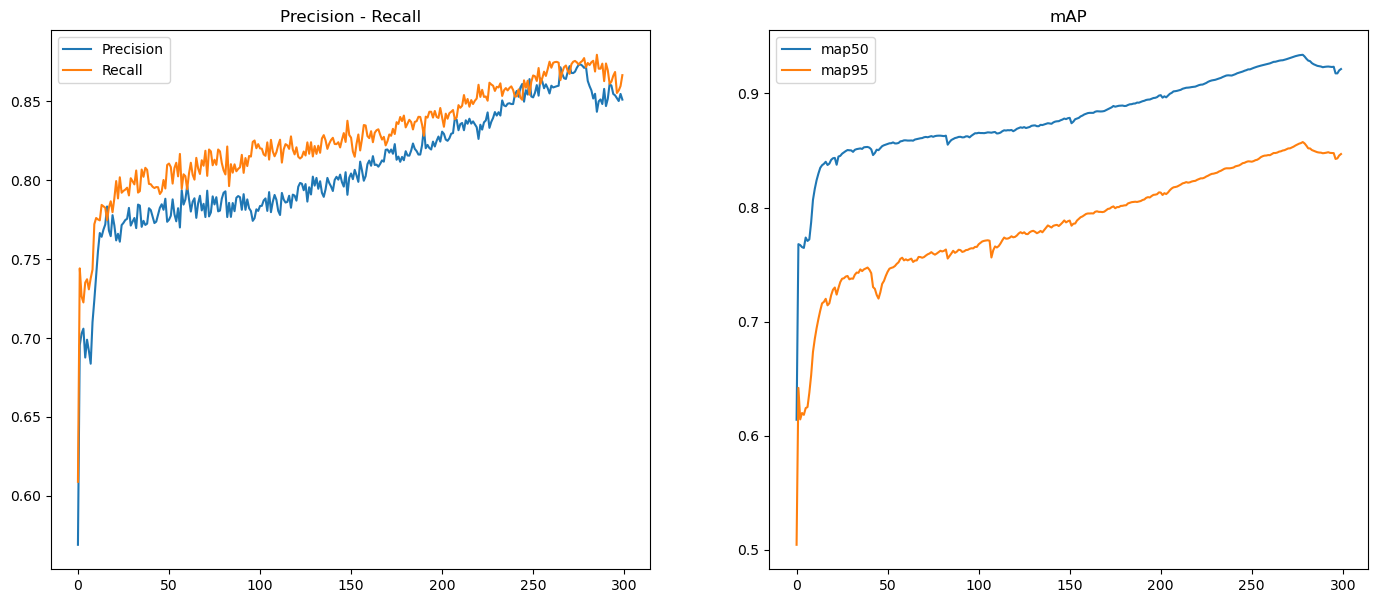

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
result_df[["Precision", "Recall"]].plot(ax=ax[0])
ax[0].set_title("Precision - Recall")
result_df[["map50", "map95"]].plot(ax=ax[1])
ax[1].set_title("mAP")
plt.show()